In [1]:
# set up path to facenet_pytorch_c
import sys
sys.path.insert(1, '/home/ubuntu/mtcnn')

In [2]:
# facenet_pytorch_c: avoid confusion with system default facenet_pytorch
from facenet_pytorch_c import MTCNN

from tqdm import tqdm
import numpy as np
import os

# pytorch
import torch
import torch.optim as optim
from torch import nn

# data handling
from torch.utils.data import DataLoader

# torchvision libs
import torchvision
from torchvision import datasets
from torchvision import transforms
import PIL

import utils


In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [4]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Available device: " + str(device))

# training hyperparameters
learning_rate = 1e-3
epochs = 400
decay_step = [200, 225, 250, 275, 300, 325, 350, 375]
decay_rate = 0.1
opt = 'Adam'    # either Adam or SGD
batch_size = 128

print_freq = int(3050/batch_size - 5)
print("print freq: {}".format(print_freq))

# data loading parameters
workers = 4

Available device: cuda:0
print freq: 18


In [5]:
x_t, b_prob_t, b_box_t, f_prob_t, f_box_t, x_v, b_prob_v, b_box_v, f_prob_v, f_box_v = utils.get_images(
    '/home/ubuntu/db_proc/db/images',
    '/home/ubuntu/db_proc/db/annotations',
    valid_percent=0.2,
    resize_shape=(48,48)
)

100%|██████████| 3605/3605 [00:24<00:00, 145.76it/s]


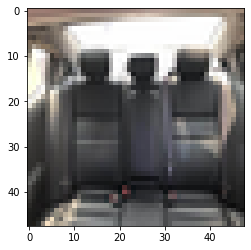

body: [0 0 0 0], face: [0 0 0 0]


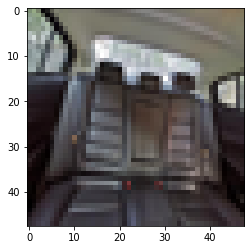

body: [0 0 0 0], face: [0 0 0 0]


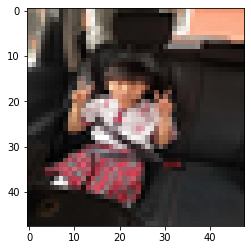

body: [ 9 11 33 37], face: [19 14 25 21]


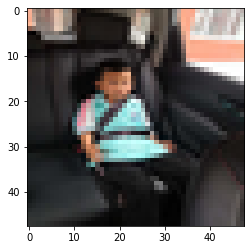

body: [11 12 33 35], face: [17 14 23 21]


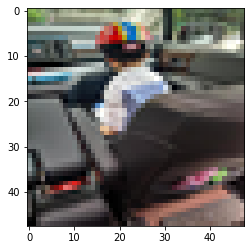

body: [15  3 30 28], face: [0 0 0 0]


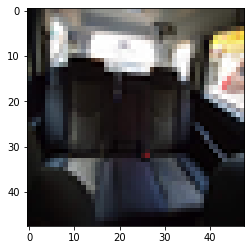

body: [0 0 0 0], face: [0 0 0 0]


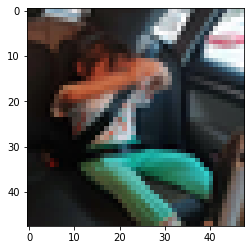

body: [ 5  5 33 33], face: [0 0 0 0]


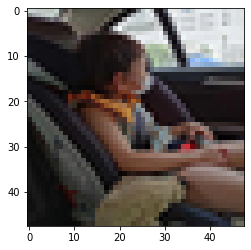

body: [ 7  5 44 37], face: [0 0 0 0]


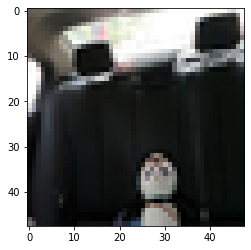

body: [0 0 0 0], face: [0 0 0 0]


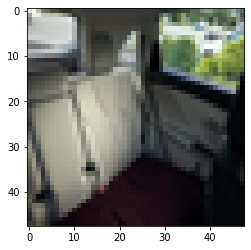

body: [0 0 0 0], face: [0 0 0 0]


In [6]:
for i in range(0, 300, 30):
    plt.imshow(x_t[i])
    plt.show()
    print("body: {}, face: {}".format(b_box_t[i], f_box_t[i]))

In [7]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

transform_valid = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

train_ds = utils.CIVDS(x_t, b_prob_t, b_box_t, f_prob_t, f_box_t, trsfm=transform_train)

valid_ds = utils.CIVDS(x_v, b_prob_v, b_box_v, f_prob_v, f_box_v, trsfm=transform_valid)

train_loader = DataLoader(
    train_ds, batch_size=batch_size,
    num_workers=workers, shuffle=True
)

valid_loader = DataLoader(
    valid_ds, batch_size=batch_size,
    num_workers=workers, shuffle=False
)

In [8]:
class PNet(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 10, kernel_size=3)
        self.prelu1 = nn.PReLU(10)
        self.pool1 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.conv2 = nn.Conv2d(10, 16, kernel_size=3)
        self.prelu2 = nn.PReLU(16)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3)
        self.prelu3 = nn.PReLU(32)
        
        self.conv4_1 = nn.Conv2d(32, 2, kernel_size=1) # body prob
        self.softmax4_1 = nn.Softmax(dim=1)
        
        self.conv4_2 = nn.Conv2d(32, 4, kernel_size=1) # body bbox
        
        self.conv4_3 = nn.Conv2d(32, 2, kernel_size=1) # face prob
        self.softmax4_3 = nn.Softmax(dim=1)
        
        self.conv4_4 = nn.Conv2d(32, 4, kernel_size=1) # face bbox
        
        self.training = True

    def forward(self, x):
        x = self.conv1(x)
        x = self.prelu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.prelu2(x)
        x = self.conv3(x)
        x = self.prelu3(x)
        
        a = self.conv4_1(x) # body prob
        a = self.softmax4_1(a)
        
        b = self.conv4_2(x) # body bbox
        
        c = self.conv4_3(x) # face prob
        c = self.softmax4_3(c)
        
        d = self.conv4_4(x) # face bbox
        
        return a, b, c, d


In [9]:
class ONet(nn.Module):

    def __init__(self, pretrained=True):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.prelu1 = nn.PReLU(32)
        self.pool1 = nn.MaxPool2d(3, 2, ceil_mode=True)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.prelu2 = nn.PReLU(64)
        self.pool2 = nn.MaxPool2d(3, 2, ceil_mode=True)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3)
        self.prelu3 = nn.PReLU(64)
        self.pool3 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=2)
        self.prelu4 = nn.PReLU(128)
        self.dense5 = nn.Linear(1152, 256)
        self.prelu5 = nn.PReLU(256)
        
        self.dense6_1 = nn.Linear(256, 2)    # body prob
        self.softmax6_1 = nn.Softmax(dim=1)
        
        self.dense6_2 = nn.Linear(256, 4)    # body bbox
        
        self.dense6_3 = nn.Linear(256, 2)    # face prob
        self.softmax6_3 = nn.Softmax(dim=1)
        
        self.dense6_4 = nn.Linear(256, 4)    # face bbox

        self.training = True

    def forward(self, x):
        x = self.conv1(x)
        x = self.prelu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.prelu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.prelu3(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.prelu4(x)
        #x = x.permute(0, 3, 2, 1).contiguous()
        x = self.dense5(x.view(x.shape[0], -1))
        x = self.prelu5(x)
        a = self.dense6_1(x)
        a = self.softmax6_1(a)
        b = self.dense6_2(x)
        c = self.dense6_3(x)
        c = self.softmax6_3(c)
        d = self.dense6_4(x)
        return a, b, c, d


In [10]:
net = ONet()
net.train()
net.to(device)

ONet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (prelu1): PReLU(num_parameters=32)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (prelu2): PReLU(num_parameters=64)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (prelu3): PReLU(num_parameters=64)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv4): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (prelu4): PReLU(num_parameters=128)
  (dense5): Linear(in_features=1152, out_features=256, bias=True)
  (prelu5): PReLU(num_parameters=256)
  (dense6_1): Linear(in_features=256, out_features=2, bias=True)
  (softmax6_1): Softmax(dim=1)
  (dense6_2): Linear(in_features=256, out_features=4, bias=True)
  (dense6_3): Linear(in_features=256, out_features=2, bias=True)
  (softmax6_3): 

In [11]:

from tensorboardX import SummaryWriter

writer = SummaryWriter(log_dir="/home/ubuntu/tensorLog") # tensorboard writer

prob_lossfn = nn.BCELoss().to(device)
bbox_lossfn = nn.MSELoss().to(device)

optimizer = None

if opt == "Adam":
    print("Optimizer: Adam")
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, amsgrad=True)
elif opt == "SGD":
    print("Optimizer: SGD")
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
else:
    print("Error")

scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=decay_step, gamma=decay_rate)

rl1, rl2, rl3, rl4 = 0, 0, 0, 0

for epoch in range(1, epochs+1):
    
    for batch_idx, data in enumerate(train_loader):
        
        im, b_prob, b_box, f_prob, f_box = data
        
        im = im.to(device)
        b_prob = b_prob.float().to(device)
        b_box = b_box.float().to(device)
        f_prob = f_prob.float().to(device)
        f_box = f_box.float().to(device)
        
        o_b_prob, o_b_box, o_f_prob, o_f_box = net(im)
        
        o_b_prob = o_b_prob.float().squeeze()
        o_b_box = o_b_box.float().squeeze()
        o_f_prob = o_f_prob.float().squeeze()
        o_f_box = o_f_box.float().squeeze()
        
        b_prob_l = prob_lossfn(o_b_prob, b_prob)
        b_box_l = bbox_lossfn(o_b_box, b_box)
        f_prob_l = prob_lossfn(o_f_prob, f_prob)
        f_box_l = bbox_lossfn(o_f_box, f_box)
        
        rl1 += b_prob_l.item()
        rl2 += b_box_l.item()
        rl3 += f_prob_l.item()
        rl4 += f_box_l.item()
        
        all_loss = b_prob_l + b_box_l + f_prob_l + f_box_l
        
        if batch_idx % print_freq == print_freq-1:
            
            print(
                "ep: {}; bpl: {:.2f}; bbl: {:.2f}; fpl: {:.2f}; fbl: {:.2f};".format(
                    epoch, rl1/print_freq, rl2/print_freq, rl4/print_freq, rl4/print_freq,
                )
            )
            writer.add_scalar('bpl', rl1/print_freq, epoch)
            writer.add_scalar('bbl', rl2/print_freq, epoch)
            writer.add_scalar('fpl', rl3/print_freq, epoch)
            writer.add_scalar('fbl', rl4/print_freq, epoch)
            
            rl1, rl2, rl3, rl4 = 0, 0, 0, 0

        optimizer.zero_grad()
        all_loss.backward()
        optimizer.step()
    
    scheduler.step()

print("finished training")
save_name = 'cd_onet.pt'
torch.save(net.state_dict(), save_name)
print('Saved model at {}'.format(save_name))

Optimizer: Adam
ep: 1; bpl: 0.83; bbl: 285.88; fpl: 156.19; fbl: 156.19;
ep: 2; bpl: 0.90; bbl: 208.03; fpl: 132.97; fbl: 132.97;
ep: 3; bpl: 0.75; bbl: 165.93; fpl: 114.61; fbl: 114.61;
ep: 4; bpl: 0.57; bbl: 121.63; fpl: 93.21; fbl: 93.21;
ep: 5; bpl: 0.45; bbl: 103.99; fpl: 87.99; fbl: 87.99;
ep: 6; bpl: 0.40; bbl: 101.16; fpl: 86.59; fbl: 86.59;
ep: 7; bpl: 0.34; bbl: 92.05; fpl: 78.62; fbl: 78.62;
ep: 8; bpl: 0.27; bbl: 82.56; fpl: 74.19; fbl: 74.19;
ep: 9; bpl: 0.26; bbl: 80.07; fpl: 73.11; fbl: 73.11;
ep: 10; bpl: 0.26; bbl: 77.41; fpl: 69.64; fbl: 69.64;
ep: 11; bpl: 0.24; bbl: 71.08; fpl: 67.17; fbl: 67.17;
ep: 12; bpl: 0.23; bbl: 70.24; fpl: 62.18; fbl: 62.18;
ep: 13; bpl: 0.21; bbl: 65.01; fpl: 60.81; fbl: 60.81;
ep: 14; bpl: 0.21; bbl: 65.97; fpl: 62.65; fbl: 62.65;
ep: 15; bpl: 0.20; bbl: 65.36; fpl: 59.36; fbl: 59.36;
ep: 16; bpl: 0.20; bbl: 60.68; fpl: 56.52; fbl: 56.52;
ep: 17; bpl: 0.22; bbl: 68.22; fpl: 61.40; fbl: 61.40;
ep: 18; bpl: 0.18; bbl: 60.08; fpl: 56.43; fbl

ep: 154; bpl: 0.00; bbl: 1.49; fpl: 2.08; fbl: 2.08;
ep: 155; bpl: 0.00; bbl: 1.44; fpl: 2.00; fbl: 2.00;
ep: 156; bpl: 0.00; bbl: 1.30; fpl: 1.80; fbl: 1.80;
ep: 157; bpl: 0.00; bbl: 1.32; fpl: 2.03; fbl: 2.03;
ep: 158; bpl: 0.00; bbl: 1.32; fpl: 1.91; fbl: 1.91;
ep: 159; bpl: 0.00; bbl: 1.31; fpl: 1.87; fbl: 1.87;
ep: 160; bpl: 0.00; bbl: 1.34; fpl: 2.22; fbl: 2.22;
ep: 161; bpl: 0.00; bbl: 1.31; fpl: 1.67; fbl: 1.67;
ep: 162; bpl: 0.00; bbl: 1.25; fpl: 1.93; fbl: 1.93;
ep: 163; bpl: 0.00; bbl: 1.15; fpl: 1.25; fbl: 1.25;
ep: 164; bpl: 0.00; bbl: 1.12; fpl: 1.85; fbl: 1.85;
ep: 165; bpl: 0.00; bbl: 1.25; fpl: 1.89; fbl: 1.89;
ep: 166; bpl: 0.00; bbl: 1.21; fpl: 1.40; fbl: 1.40;
ep: 167; bpl: 0.00; bbl: 1.20; fpl: 1.99; fbl: 1.99;
ep: 168; bpl: 0.00; bbl: 1.17; fpl: 1.69; fbl: 1.69;
ep: 169; bpl: 0.00; bbl: 1.11; fpl: 1.91; fbl: 1.91;
ep: 170; bpl: 0.00; bbl: 1.13; fpl: 1.59; fbl: 1.59;
ep: 171; bpl: 0.00; bbl: 1.10; fpl: 1.51; fbl: 1.51;
ep: 172; bpl: 0.00; bbl: 1.06; fpl: 1.82; fbl:

ep: 309; bpl: 0.00; bbl: 0.56; fpl: 1.13; fbl: 1.13;
ep: 310; bpl: 0.00; bbl: 0.56; fpl: 0.85; fbl: 0.85;
ep: 311; bpl: 0.00; bbl: 0.59; fpl: 1.06; fbl: 1.06;
ep: 312; bpl: 0.00; bbl: 0.56; fpl: 0.97; fbl: 0.97;
ep: 313; bpl: 0.00; bbl: 0.56; fpl: 0.88; fbl: 0.88;
ep: 314; bpl: 0.00; bbl: 0.55; fpl: 0.84; fbl: 0.84;
ep: 315; bpl: 0.00; bbl: 0.59; fpl: 0.85; fbl: 0.85;
ep: 316; bpl: 0.00; bbl: 0.56; fpl: 0.98; fbl: 0.98;
ep: 317; bpl: 0.00; bbl: 0.57; fpl: 1.32; fbl: 1.32;
ep: 318; bpl: 0.00; bbl: 0.55; fpl: 0.90; fbl: 0.90;
ep: 319; bpl: 0.00; bbl: 0.58; fpl: 0.84; fbl: 0.84;
ep: 320; bpl: 0.00; bbl: 0.57; fpl: 1.09; fbl: 1.09;
ep: 321; bpl: 0.00; bbl: 0.56; fpl: 0.88; fbl: 0.88;
ep: 322; bpl: 0.00; bbl: 0.58; fpl: 0.95; fbl: 0.95;
ep: 323; bpl: 0.00; bbl: 0.56; fpl: 0.71; fbl: 0.71;
ep: 324; bpl: 0.00; bbl: 0.57; fpl: 1.19; fbl: 1.19;
ep: 325; bpl: 0.00; bbl: 0.55; fpl: 0.89; fbl: 0.89;
ep: 326; bpl: 0.00; bbl: 0.56; fpl: 0.99; fbl: 0.99;
ep: 327; bpl: 0.00; bbl: 0.58; fpl: 0.77; fbl:

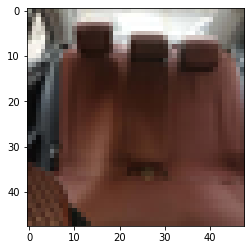

tb: 0; pb: 0
tf: 0; pf: 0
body: [-0. -0. -0. -0.]
face: [-0.  0.  0.  0.]


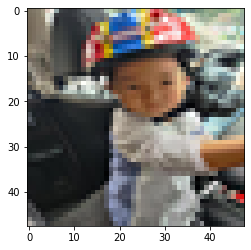

tb: 1; pb: 1
tf: 1; pf: 1
body: [13.  4. 41. 38.]
face: [15.  6. 22. 13.]


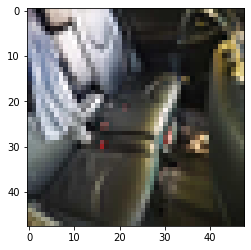

tb: 0; pb: 0
tf: 0; pf: 0
body: [0. 0. 0. 0.]
face: [-0.  0.  0.  0.]


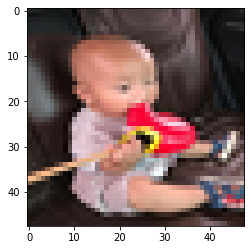

tb: 1; pb: 1
tf: 1; pf: 0
body: [ 9.  9. 42. 37.]
face: [1. 4. 5. 8.]


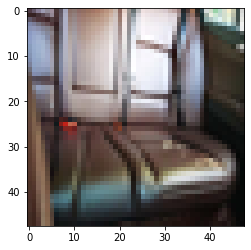

tb: 0; pb: 0
tf: 0; pf: 0
body: [2. 2. 2. 1.]
face: [1. 2. 1. 2.]


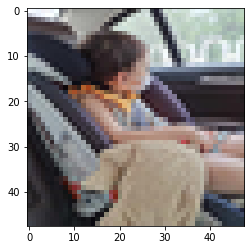

tb: 1; pb: 1
tf: 0; pf: 0
body: [ 6.  5. 43. 34.]
face: [ 0. -0. -0. -0.]


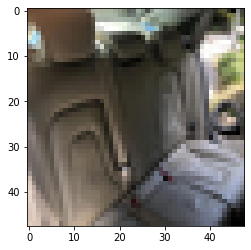

tb: 0; pb: 0
tf: 0; pf: 0
body: [ 0. -0.  0.  0.]
face: [0. 0. 0. 0.]


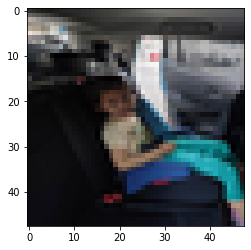

tb: 1; pb: 1
tf: 1; pf: 1
body: [11. 17. 43. 46.]
face: [27. 22. 40. 38.]


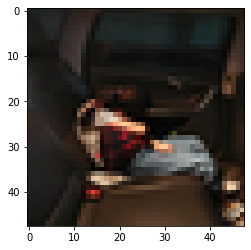

tb: 1; pb: 1
tf: 0; pf: 0
body: [ 8.  8. 33. 34.]
face: [5. 4. 6. 6.]


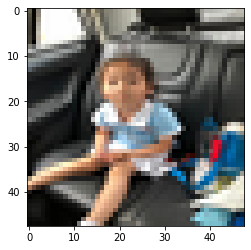

tb: 1; pb: 1
tf: 1; pf: 1
body: [10.  9. 34. 37.]
face: [17. 12. 26. 23.]


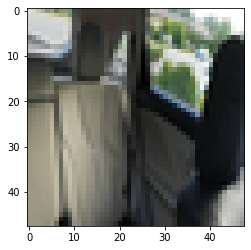

tb: 0; pb: 0
tf: 0; pf: 0
body: [-0.  0.  0. -0.]
face: [0. 0. 0. 0.]


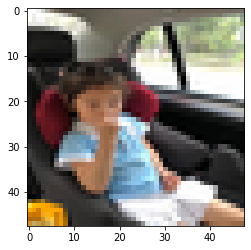

tb: 1; pb: 1
tf: 1; pf: 1
body: [ 6. 11. 37. 48.]
face: [14. 15. 24. 26.]


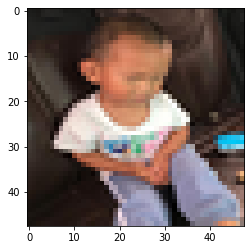

tb: 1; pb: 1
tf: 1; pf: 1
body: [10.  1. 41. 42.]
face: [18.  7. 32. 23.]


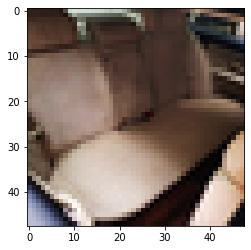

tb: 0; pb: 0
tf: 0; pf: 0
body: [-0. -0. -1. -0.]
face: [ 0.  0. -0.  0.]


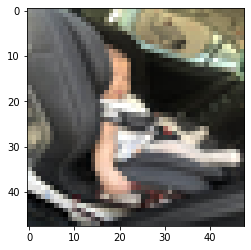

tb: 1; pb: 1
tf: 0; pf: 0
body: [12.  7. 31. 42.]
face: [ 0. -0.  1.  0.]


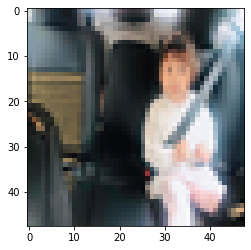

tb: 1; pb: 1
tf: 1; pf: 1
body: [25.  5. 42. 36.]
face: [29.  9. 38. 20.]


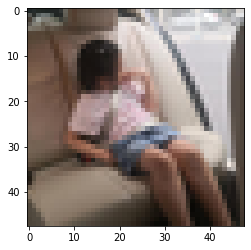

tb: 1; pb: 1
tf: 0; pf: 0
body: [ 9.  8. 31. 37.]
face: [3. 1. 3. 2.]


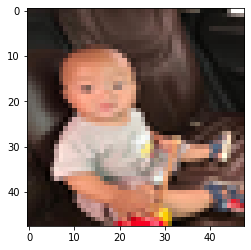

tb: 1; pb: 1
tf: 1; pf: 1
body: [ 5. 11. 32. 46.]
face: [ 9. 12. 23. 27.]


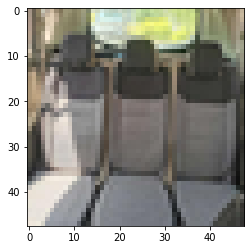

tb: 0; pb: 0
tf: 0; pf: 0
body: [ 0.  0. -0.  0.]
face: [-0.  0. -0. -0.]


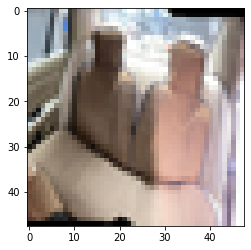

tb: 0; pb: 0
tf: 0; pf: 0
body: [-0.  0.  1. -0.]
face: [1. 1. 1. 0.]


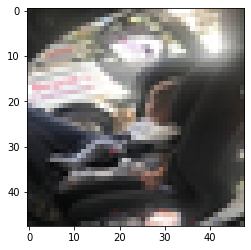

tb: 1; pb: 1
tf: 0; pf: 0
body: [18. 15. 35. 39.]
face: [0. 0. 1. 1.]


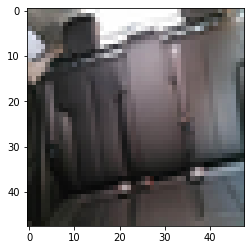

tb: 0; pb: 0
tf: 0; pf: 0
body: [-0. -0. -0. -0.]
face: [-0. -0. -0. -0.]


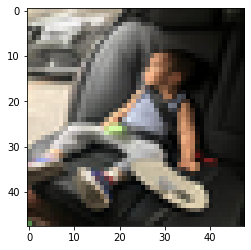

tb: 1; pb: 1
tf: 1; pf: 1
body: [17.  8. 40. 37.]
face: [25. 10. 30. 17.]


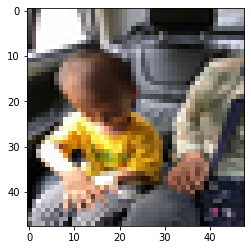

tb: 1; pb: 1
tf: 0; pf: 1
body: [-2. 10. 28. 43.]
face: [ 8. 15. 24. 33.]


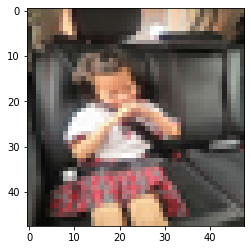

tb: 1; pb: 1
tf: 1; pf: 1
body: [ 7. 10. 30. 36.]
face: [13. 11. 21. 20.]


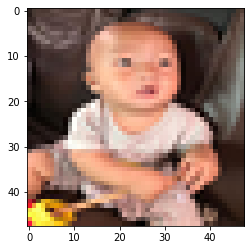

tb: 1; pb: 1
tf: 1; pf: 1
body: [ 5.  2. 47. 47.]
face: [14.  3. 30. 22.]


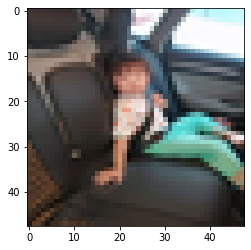

tb: 1; pb: 1
tf: 1; pf: 0
body: [10.  8. 40. 41.]
face: [-1. -0. -1. -0.]


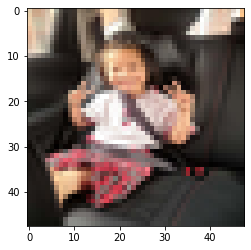

tb: 1; pb: 1
tf: 1; pf: 1
body: [ 8.  6. 40. 34.]
face: [17.  9. 26. 18.]


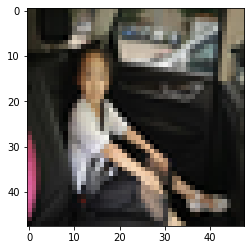

tb: 1; pb: 1
tf: 1; pf: 1
body: [ 7.  8. 32. 44.]
face: [12. 11. 18. 21.]


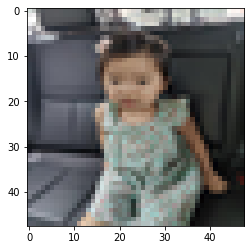

tb: 1; pb: 1
tf: 1; pf: 1
body: [ 9.  5. 41. 39.]
face: [17.  7. 27. 20.]


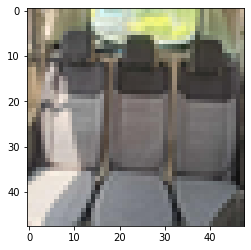

tb: 0; pb: 0
tf: 0; pf: 0
body: [ 0. -0. -0. -0.]
face: [-0. -0. -0.  0.]


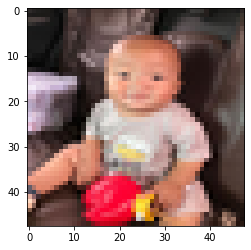

tb: 1; pb: 1
tf: 1; pf: 1
body: [ 8.  5. 42. 44.]
face: [17.  6. 31. 23.]


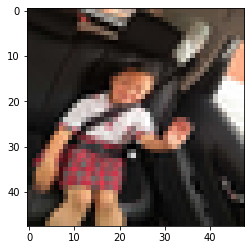

tb: 1; pb: 1
tf: 1; pf: 1
body: [ 7. 10. 36. 35.]
face: [17. 13. 26. 21.]


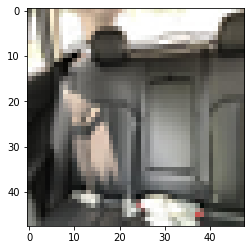

tb: 0; pb: 0
tf: 0; pf: 0
body: [-0.  0. -0. -0.]
face: [0. 0. 0. 0.]


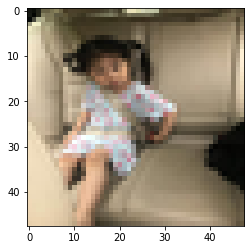

tb: 1; pb: 1
tf: 1; pf: 1
body: [ 7.  3. 28. 35.]
face: [12.  5. 18. 14.]


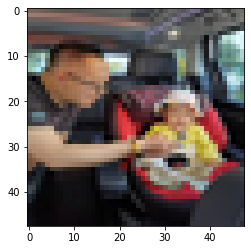

tb: 1; pb: 1
tf: 1; pf: 0
body: [ 9. 14. 35. 35.]
face: [ 6. 11. 14. 19.]


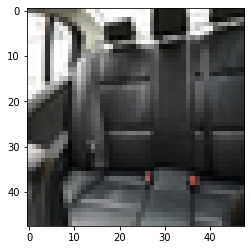

tb: 0; pb: 0
tf: 0; pf: 0
body: [0. 0. 0. 0.]
face: [-0.  0. -0.  0.]
total: 721
body accuracy: 98.2%
face accuracy: 93.2%
true face count: 323


In [12]:
total = len(valid_ds)
b_err, f_err = 0, 0
bt, bp, ft, fp = [], [], [], []

hasFace = 0

for idx in range(0, total):
    
    obp, obb, ofp, ofb  = net(valid_ds[idx][0].unsqueeze(0).to(device))
    obp, ofp = obp.squeeze(), ofp.squeeze()
    
    obp = int(obp[0] > obp[1])
    ofp = int(ofp[0] > ofp[1])

    tbp = int(b_prob_v[idx][0] > b_prob_v[idx][1])
    tfp = int(f_prob_v[idx][0] > f_prob_v[idx][1])
    
    hasFace += tfp

    b_err += (obp != tbp)
    f_err += (ofp != tfp)
        
    if idx % 20 == 0:
        plt.imshow(transforms.ToPILImage()(valid_ds[idx][0]))
        plt.show()
        print("tb: {}; pb: {}\ntf: {}; pf: {}".format(int(tbp), int(obp), int(tfp), int(ofp)))
        print("body: " + str(np.rint(obb.cpu().detach().squeeze().numpy())))
        print("face: " + str(np.rint(ofb.cpu().detach().squeeze().numpy())))

print("total: {}".format(total))
print("body accuracy: {:.1f}%".format(100*(total-b_err)/total))
print("face accuracy: {:.1f}%".format(100*(total-f_err)/total))
print("true face count: {}".format(hasFace))

"""
p, r, f1 = utils.f1_score(truth, pred, 0)
print("precision: {:.2f}, recall: {:.2f}, f1: {:.2f}".format(p, r, f1))
print("valid_ds length: {}".format(len(valid_ds)))
print("age dist: ", end='')
""";